# Step-by-step to your first linear regression model

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/ml_in_ms_wt24/blob/main/wt_25_ml_in_ms/06_ex/step-by-step-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this tutorial, we will build and train a linear regression model from scratch using JAX. We will:

1. Download and prepare data 🗂
2. Understand the mathematics behind linear regression
3. Define and compute a loss function
4. Optimize parameters using gradients
5. Iteratively improve our model
6. Evaluate and validate results

We'll use JAX for efficient numerical computing and automatic differentiation.

### 1. Get data
- We use `pandas` to load the `tendency to crystallize` of polymers dataset
- Our ML model will learn how to predict the `tendency to crystallize` (column `value`) from the fingerprints


In [1]:
import pandas as pd

df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/materials_datasets/refs/heads/main/polymer_tendency_to_crystalize/polymers_tend_to_crystalize.json"
)
# ... and easy-peasy
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(839.0858585858584, 0.5, 'Correlation Coefficient')

<Figure size 1400x1000 with 0 Axes>

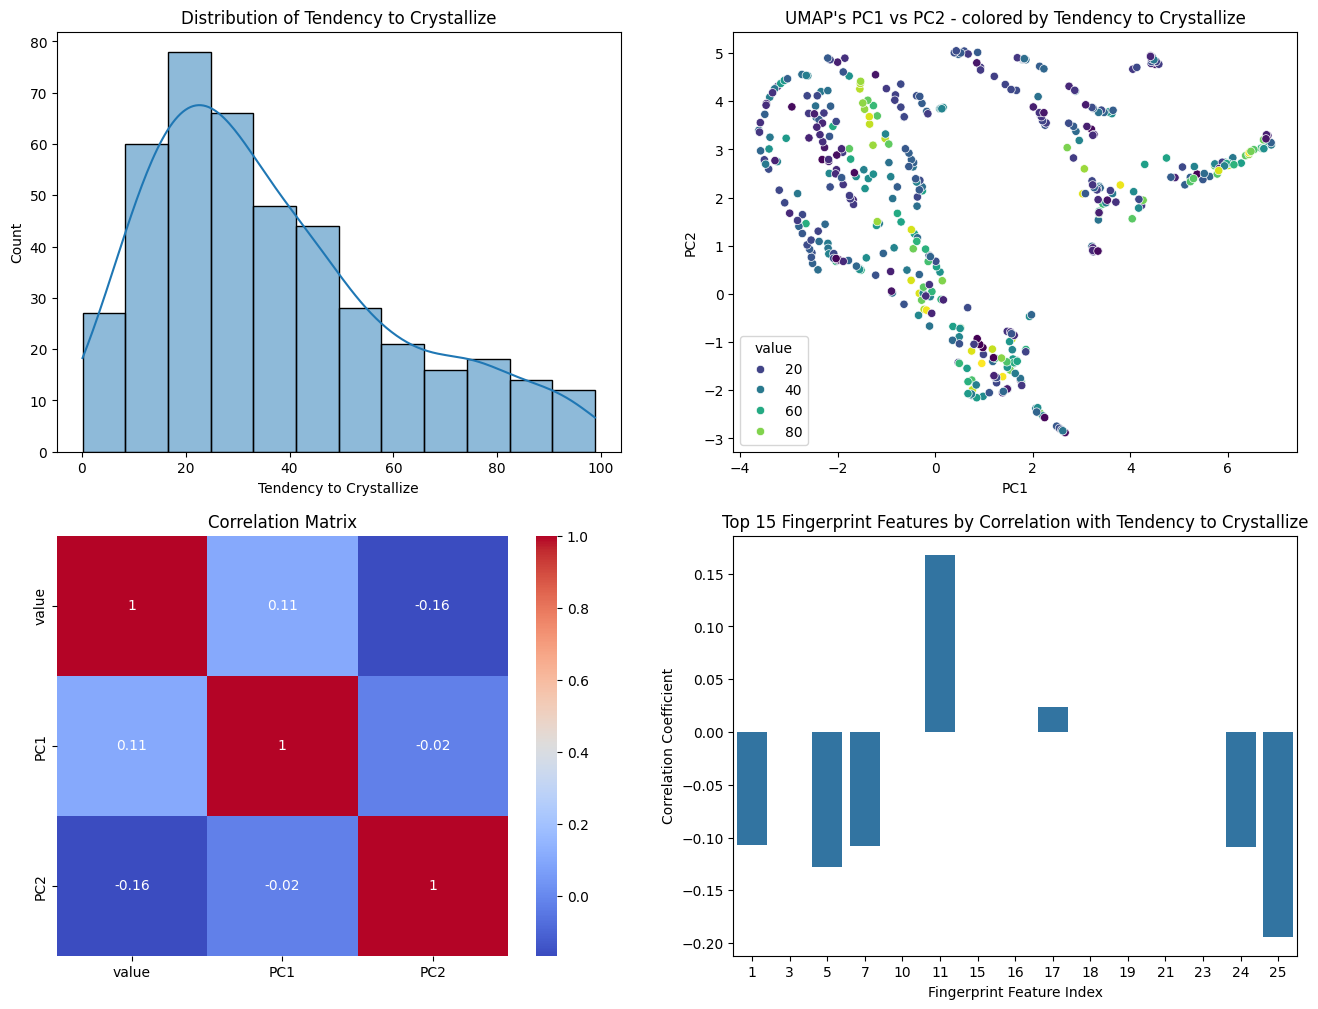

In [2]:
import seaborn as sns
import numpy as np
import umap

import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(14, 10))

# Create a subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of the tendency to crystallize values
sns.histplot(df["value"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Tendency to Crystallize")
axes[0, 0].set_xlabel("Tendency to Crystallize")

# 2. Calculate and plot the first 5 principal components of the fingerprints
# Extract fingerprint data
fingerprints = np.vstack(df["fingerprint"].values)

# Parameters min_dist, n_neighbors, n_components, and metric
# See https://umap-learn.readthedocs.io/en/latest/parameters.html for details
fit = umap.UMAP()

umap_results = fit.fit_transform(fingerprints)
df_umap = pd.DataFrame(
    umap_results, columns=[f"PC{i+1}" for i in range(umap_results.shape[1])]
)
df_umap = pd.concat([df_umap, df["value"].reset_index(drop=True)], axis=1)


# 3. Scatter plot of UMAPs PC1 vs PC2, colored by tendency to crystallize
sc = sns.scatterplot(
    x="PC1", y="PC2", hue="value", palette="viridis", data=df_umap, ax=axes[0, 1]
)
axes[0, 1].set_title("UMAP's PC1 vs PC2 - colored by Tendency to Crystallize")

# 4. Heatmap of correlation between first 5 PCA components and tendency to crystallize
corr_cols = ["value"] + [f"PC{i+1}" for i in range(2)]
corr_matrix = df_umap[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Correlation Matrix")


# 4. Feature importance analysis
# Find fingerprint dimensions with highest correlation to the target value
correlation_values = []
for i in range(fingerprints.shape[1]):
    correlation = np.corrcoef(fingerprints[:, i], df["value"])[0, 1]
    correlation_values.append((i, correlation))

# Sort by absolute correlation value
correlation_values.sort(key=lambda x: abs(x[1]), reverse=True)

# Plot top 15 most correlated fingerprint dimensions
top_indices = [x[0] for x in correlation_values[:15]]
top_corrs = [x[1] for x in correlation_values[:15]]
sns.barplot(x=top_indices, y=top_corrs, ax=axes[1, 1])
axes[1, 1].set_title(
    "Top 15 Fingerprint Features by Correlation with Tendency to Crystallize"
)
axes[1, 1].set_xlabel("Fingerprint Feature Index")
axes[1, 1].set_ylabel("Correlation Coefficient")

### 2. Math and model

Our model is a linear regression model defined as:

$$
\mathbf{y} = \mathbf{X} \mathbf{w} + \mathbf{b}
$$

which expands to:

$$
\begin{bmatrix}
y_{1}\\ y_{2}\\  \vdots \\  y_{n}  
\end{bmatrix} = \begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1d} \\
x_{21} & x_{22} & \dots & x_{2d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nd} \\
\end{bmatrix}\begin{bmatrix}
w_{1} \\ w_{2} \\ \vdots \\ w_{d}\\
\end{bmatrix}
+
\begin{bmatrix}
b \\ b \\ \vdots \\ b\\
\end{bmatrix}
$$

Where:

- $\mathbf{X}$ (INPUT): Represents the fingerprints, features, or descriptors of the materials. Its shape is `#materials` (or `#samples`) x `#fingerprints`.
- $\mathbf{w}$: Is the weight vector containing adjustable parameters. It has a shape of `#fingerprints`.
- $\mathbf{b}$: Represents the bias term, a scalar value.
- $\mathbf{y}$ (OUTPUT): Represents the prediction, specifically the tendency of polymers to crystallize. Its shape is `#materials`.


In [3]:
# "JAX is like NumPy but with great automatic differentiation and GPU support,
# for high-performance machine learning research."

import jax.numpy as jnp
import jax
import numpy as np

# Set NumPy print options for better readability
np.set_printoptions(precision=2)

# Set seed to make reproducible
np.random.seed(20)


# Define a simple linear model function like above
@jax.jit
def linear_model(X, w, b):
    return jnp.dot(X, w.T) + b


# Let's test it and make an example with random data
number_of_materials = 10
number_of_fingerprints = 3
number_of_outputs = 1  # because tendency to crystalize is a scalar
X = jnp.array(np.random.rand(number_of_materials, number_of_fingerprints))
w = jnp.array(np.random.rand(number_of_outputs, number_of_fingerprints))
b = jnp.array(np.random.rand(number_of_outputs))


print(
    f"""
{X = 
}

{w = 
}

{b = 
}

{linear_model(X, w, b) = 
}
"""
)


X = 
Array([[0.59, 0.9 , 0.89],
       [0.82, 0.04, 0.69],
       [0.38, 0.52, 0.66],
       [0.19, 0.27, 0.72],
       [0.78, 0.85, 0.78],
       [0.04, 0.12, 0.75],
       [0.24, 0.25, 0.86],
       [0.95, 0.56, 0.18],
       [0.77, 0.49, 0.63],
       [0.84, 0.46, 0.5 ]], dtype=float32)

w = 
Array([[0.68, 0.65, 0.27]], dtype=float32)

b = 
Array([0.07], dtype=float32)

linear_model(X, w, b) = 
Array([[1.29],
       [0.83],
       [0.84],
       [0.57],
       [1.36],
       [0.37],
       [0.63],
       [1.13],
       [1.08],
       [1.07]], dtype=float32)



### 3. Compute the loss of our regression

We use the mean squared error (MSE) for this:

$$
\text{MSE} = L = \frac{1}{N} \sum_i^N \left( y_i - \hat{y}_i\right)^2
$$

Where:
- $y_i$ are the true values.
- $\hat{y}_i$ are the predictions.
- $N$ is the number of samples.


Let's compute it with the tendency to crystallize dataset from above

In [4]:
# Set seed to make reproducible
np.random.seed(10)

# Get the fingerprints and true values of the tendency to crystal
tendency_crystallize_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))

# Initialize w and b using random values
# `randn` draws values from a standard normal distribution
n_outputs = 1
w = jnp.array(np.random.randn(n_outputs, fp_array.shape[1]))
b = jnp.array(np.random.randn(n_outputs))


# Get the prediction
prediction = linear_model(fp_array, w, b).flatten()


# Define a loss function, here we use Mean Squared Error (MSE)
@jax.jit
def loss_mse(truth, pred):
    return jnp.mean((truth - pred) ** 2)


# Compute the loss
print(
    f"""{tendency_crystallize_array.shape = 
}  

{prediction.flatten().shape = 
}

{loss_mse(tendency_crystallize_array, prediction) = 
}
"""
)

tendency_crystallize_array.shape = 
(432,)  

prediction.flatten().shape = 
(432,)

loss_mse(tendency_crystallize_array, prediction) = 
Array(2391.01, dtype=float32)



### 4. Optimize $\mathbf{w}$ and $\vec{b}$ by gradients

Optimize by computing the derivatives of $L$ with respect to $\mathbf{w}$ and $\vec{b}$.
$$
\frac{\partial L} {\partial w_{ij}}, \frac{\partial L} {\partial b_i},
$$

and reducing the loss by taking a step in the negative gradient direction
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}},
$$
and
$$
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

$\eta$ is the learning rate.

In [5]:
# Create a wrapper to combine predictions and loss
# This function will take weights, bias, true values, and fingerprints,
# and return the loss value
@jax.jit
def predict_and_loss_wrapper(w, b, truth, fp):
    pred = linear_model(fp, w, b)
    return loss_mse(truth, pred)


predict_and_loss_wrapper(w, b, tendency_crystallize_array, fp_array)

Array(2284.39, dtype=float32)

In [6]:
# Build the gradient function for `predict_and_loss_wrapper` with the jax.grad()
# jax.grad() automatically computes the gradients of a function with respect to its inputs.
# The first argument is the function to compute gradients for,
# and the second argument is a tuple indicating which arguments to differentiate.
# In this case, we want to compute gradients with respect to the first two arguments (w and b):
grad_func = jax.grad(predict_and_loss_wrapper, (0, 1))


# Compute the gradients with
grads_w, grads_b = grad_func(w, b, tendency_crystallize_array, fp_array)
print(
    f"""{grads_w.shape = 
}

{grads_w = 
}

{grads_b.shape = 
}

{grads_b = 
}
"""
)

grads_w.shape = 
(1, 2048)

grads_w = 
Array([[ -0.16, -15.07,  -0.56, ...,  -0.83,   0.  ,  -2.01]], dtype=float32)

grads_b.shape = 
(1,)

grads_b = 
Array([-73.89], dtype=float32)



### 5. Iteratively optimize w and b

We optimize by subtracting the (gradient * learning) rate from the original $\mathbf{w}$ and b$
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}}, \quad
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

$\eta$ is the learning rate.


/tmp/ipykernel_4050744/3791249681.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


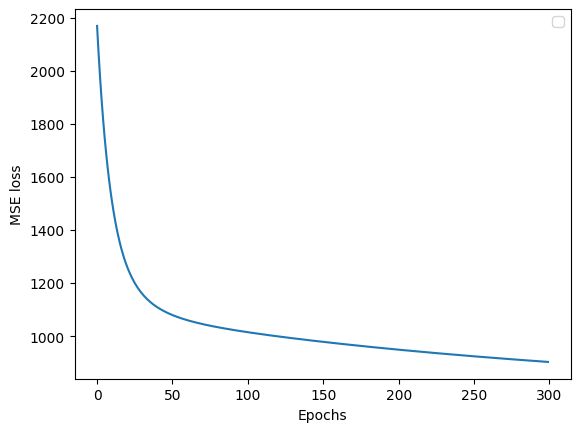

In [7]:
import matplotlib.pyplot as plt

# Get the fingerprints and true values of the tendency to crystal
tendency_crystallize_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))

# Copy the initial weights and biases for training
# keeps the original weights and biases intact
b_train = b.copy()
w_train = w.copy()

# Set the number of training loops and learning rate
loops = 300
eta = 1e-4  # learning rate

# Initialize a list to store losses for each epoch
losses = []
for i in range(loops):
    # Compute the gradients
    grads_w, grads_b = grad_func(w_train, b_train, tendency_crystallize_array, fp_array)
    # Update the weights and biases using the gradients
    w_train = w_train - eta * grads_w  # easy-peasy it is!
    b_train = b_train - eta * grads_b
    # Compute the loss for the current weights and biases
    my_loss = predict_and_loss_wrapper(
        w_train, b_train, tendency_crystallize_array, fp_array
    )
    # Append the loss to the list
    losses.append(my_loss)

plt.plot(range(loops), losses)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

### 6. Validate

Let's visualize the model performance using a parity plot. We'll compare predictions from the initial parameters ($b$ and $\mathbf{w}$) with those from the optimized parameters. This helps us assess how well the model has learned to predict the tendency to crystallize.


MSE for initial w/b = 
2284.38916015625

MSE for optimized w/b = 
902.7644653320312
    


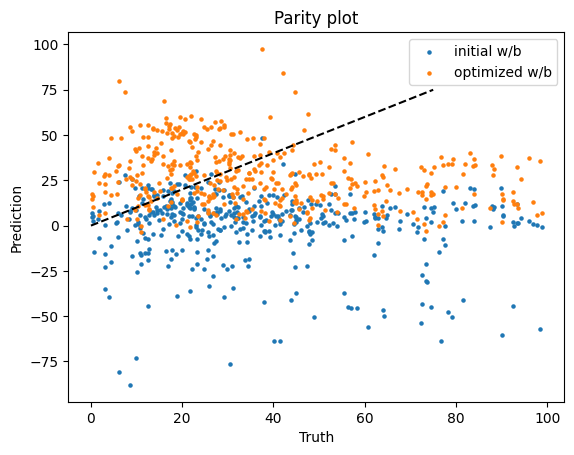

In [8]:
import matplotlib.pyplot as plt

# Predictions with initial and optimized weights and biases
pred_init = linear_model(fp_array, w, b).flatten()

# Predictions with optimized weights and biases
pred_opt = linear_model(fp_array, w_train, b_train).flatten()

plt.scatter(tendency_crystallize_array, pred_init, s=5, label="initial w/b")
plt.scatter(tendency_crystallize_array, pred_opt, s=5, label="optimized w/b")
plt.plot([0, 75], [0, 75], "k--")

plt.title("Parity plot")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.legend()

print(
    f"""
MSE for initial w/b = 
{predict_and_loss_wrapper(w, b, tendency_crystallize_array, fp_array)}
    
MSE for optimized w/b = 
{predict_and_loss_wrapper(w_train, b_train, tendency_crystallize_array, fp_array)}
    """
)

### 7. Batching

Training datasets in machine learning are often very large. That's why we use batching to split the data into small batches of data. 

batched_tendency_crystallize_array.shape = (13, 32)
batched_fp_array.shape = (13, 32, 2048)
indices = array([ 0,  6,  8,  3,  7,  2,  4,  9, 11, 10,  1,  5, 12])
Loss curve


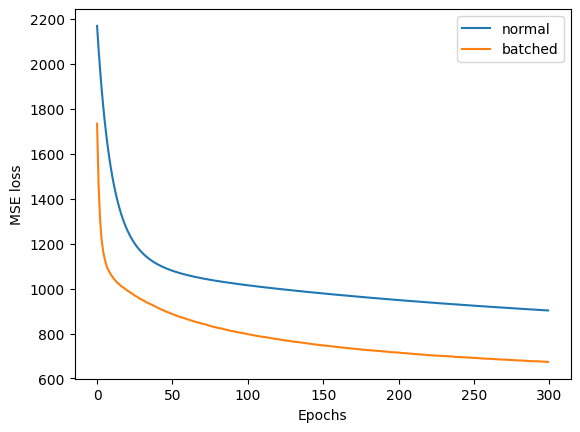

In [9]:
import matplotlib.pyplot as plt

batch_size = 32  # choose this
n_data_points = tendency_crystallize_array.shape[0]  # 432 data points
new_n_data_points = int(n_data_points / batch_size) * batch_size  # 416


tendency_crystallize_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))
# We take new_n_data_points and reshape into batches by adding one dimension
# -1 means to compute the value -> 416 / 32 = 13
batched_tendency_crystallize_array = tendency_crystallize_array[
    :new_n_data_points
].reshape(-1, batch_size)
batched_fp_array = fp_array[:new_n_data_points].reshape(
    -1, batch_size, fp_array.shape[1]
)
print(f"{batched_tendency_crystallize_array.shape = }")
print(f"{batched_fp_array.shape = }")

# We shuffle the indices of the batches to randomly train the weights
indices = np.arange(new_n_data_points / batch_size, dtype=int)
np.random.shuffle(indices)
print(f"{indices = }")

# Save these for later
b_train_batch = b.copy()
w_train_batch = w.copy()

eta = 5e-5  # learning rate

batched_losses = []
for i in range(loops):
    # We shuffle here every time
    np.random.shuffle(indices)

    for ind in indices:
        grads_w, grads_b = grad_func(
            w_train_batch,
            b_train_batch,
            batched_tendency_crystallize_array[ind],
            batched_fp_array[ind],
        )
        w_train_batch -= eta * grads_w  # easy-peasy it is!
        b_train_batch -= eta * grads_b

    # compute loss on whole dataset but after each epoch
    my_loss = predict_and_loss_wrapper(
        w_train_batch, b_train_batch, tendency_crystallize_array, fp_array
    )

    batched_losses.append(my_loss)

plt.plot(range(loops), losses, label="normal")
plt.plot(range(loops), batched_losses, label="batched")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
print("Loss curve")

### 8. Observe the gradients 

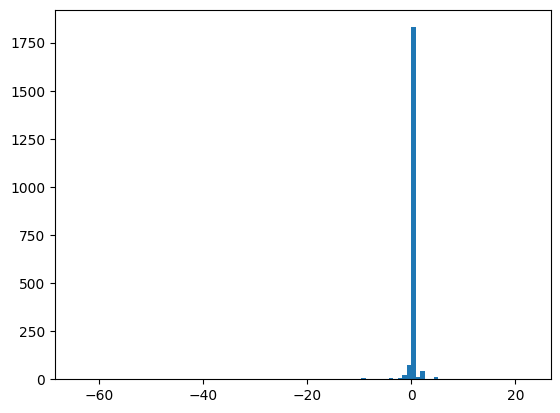

In [10]:
_ = plt.hist(grads_w.flatten(), bins=100)

- Most of the are close to zero. 
- Gradients close to zero will not change $\mathbf{w}$ and $b$. Remember:
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}}, \quad
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

- This is because of the fingerprints and their range(e.g., between 0 and 1)
- To overcome this, we scale the fingerprints to unit variance

In [11]:
from sklearn.preprocessing import MinMaxScaler

df["std_fingerprint"] = MinMaxScaler().fit_transform(np.vstack(df.fingerprint)).tolist()
df

,smiles,property,value,fingerprint,std_fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<Axes: >

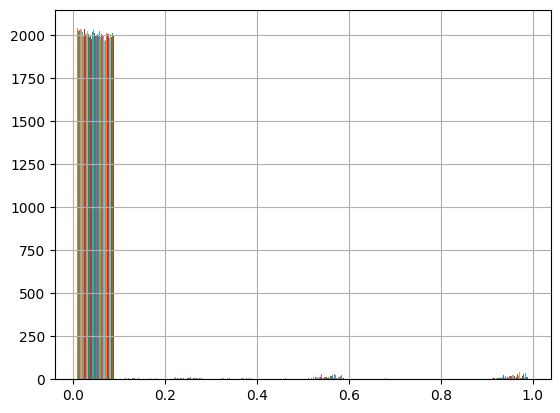

In [12]:
df["std_fingerprint"].hist()

### 9. Retrain using the standardized fingerprints

- Copy and past code from above and run.
- Use the std_fingerprints instead

In [13]:
import matplotlib.pyplot as plt


# Get the input and output
tendency_crystallize_array = jnp.array(df["value"].values)
# we get the standardized fingerprints instead
fp_array = jnp.array(np.vstack(df["std_fingerprint"].values))

batch_size = 32  # choose this
n_data_points = tendency_crystallize_array.shape[0]  # 432 data points
new_n_data_points = int(n_data_points / batch_size) * batch_size  # 416

# We take new_n_data_points and reshape into batches by adding one dimension
# -1 means to compute the value -> 416 / 32 = 13
batched_tendency_crystallize_array = tendency_crystallize_array[
    :new_n_data_points
].reshape(-1, batch_size)
batched_fp_array = fp_array[:new_n_data_points].reshape(
    -1, batch_size, fp_array.shape[1]
)
print(f"{batched_tendency_crystallize_array.shape = }")
print(f"{batched_fp_array.shape = }")

# We shuffle the indices of the batches to randomly train the weights
indices = np.arange(new_n_data_points / batch_size, dtype=int)
np.random.shuffle(indices)
print(f"{indices = }")

# Save these for later
b_train_scale_batch = b.copy()
w_train_scale_batch = w.copy()

eta = 5e-4  # learning rate

scaled_losses = []
for i in range(loops):
    # We shuffle here every time
    np.random.shuffle(indices)

    for ind in indices:
        grads_w, grads_b = grad_func(
            w_train_scale_batch,
            b_train_scale_batch,
            batched_tendency_crystallize_array[ind],
            batched_fp_array[ind],
        )
        w_train_scale_batch -= eta * grads_w  # easy-peasy it is!
        b_train_scale_batch -= eta * grads_b

    # compute loss on whole dataset but after each epoch
    my_loss = predict_and_loss_wrapper(
        w_train_scale_batch, b_train_scale_batch, tendency_crystallize_array, fp_array
    )
    scaled_losses.append(my_loss)

batched_tendency_crystallize_array.shape = (13, 32)
batched_fp_array.shape = (13, 32, 2048)
indices = array([10,  3, 12,  8, 11,  2,  1,  7,  9,  4,  0,  6,  5])


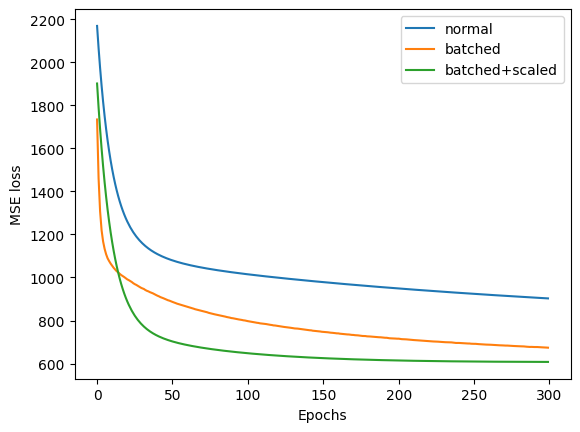

In [14]:
plt.plot(range(loops), losses, label="normal")
plt.plot(range(loops), batched_losses, label="batched")
plt.plot(range(loops), scaled_losses, label="batched+scaled")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
# plt.yscale("log")

init           : MSE = 2042.413 , R2 =  -2.634
normal         : MSE = 1844.922 , R2 =  -2.283
batch          : MSE = 1537.640 , R2 =  -1.736
scale_batch    : MSE =  515.012 , R2 =   0.084


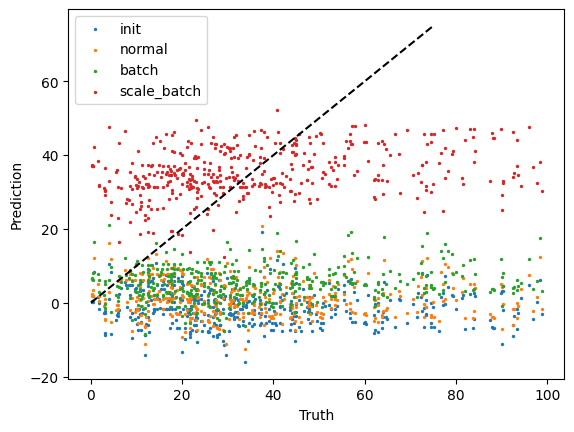

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

pred_init = linear_model(fp_array, w, b).flatten()
pred_opt = linear_model(fp_array, w_train, b_train).flatten()
pred_batch = linear_model(fp_array, w_train_batch, b_train_batch).flatten()
pred_scale_batch = linear_model(
    fp_array, w_train_scale_batch, b_train_scale_batch
).flatten()

pred_dict = {
    "init": pred_init,
    "normal": pred_opt,
    "batch": pred_batch,
    "scale_batch": pred_scale_batch,
}

for name, pred in pred_dict.items():
    plt.scatter(tendency_crystallize_array, pred, s=2, label=name)
    print(
        f"{name:15}: MSE = {mean_squared_error(tendency_crystallize_array, pred):8.3f} , R2 = {r2_score(tendency_crystallize_array, pred):7.3f}"
    )

plt.plot([0, 75], [0, 75], "k--")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.legend()

## Tutorial UMAP

1. Adjust the parameters min_dist, n_neighbors, n_components, and metric of the UMAP function.
2. Read [details](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-neighbors) to get more understanding about the parameters
3. Try to find a set of parameters that maximizes the values in the correlation matrix

## Tutorial loss function

1. Modify the batch size to [1, 10,  32, and 64] and observe how the learning curve changes.
2. Replace the MSE with the mean absolute error (MAE) function; observe how the learning changes

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

3. See the scalers at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. Replace the MinMaxScaler with the `QuantileTransformer` and `RobustScaler`
4. Add a column with normalized tendencies to crystallize to the pandas dataframe and train a model with these normalized models.



# Tutorial jax

1. Compute the gradient of the `tanh` (`jnp.tanh`) function at `2` using JAX $\nabla \text{tanh(2)} = $
2. Compute $\Delta \text{tanh(2)}  = \nabla \nabla \text{tanh(2)}$

## Tutorial 

1. Make a copy of the notebook
2. Replace the tendency to crystallize dataset with dataset polymer band gap dataset. Use `pd.read_parquet('https://github.com/kuennethgroup/materials_datasets/blob/main/polymer_band_gap_computational/export_egc_fps.parquet')` to read the data.